In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


In [2]:
diff = "5percent"
pressure = 1

# Set the detector size depending on the pressure
density = 5.987*pressure
M = 1000/0.9
det_size = 1000*np.cbrt((4 * M) / (np.pi * density))/2.0
print(det_size)

# Load in the signal metadata
nubb_meta = pd.read_hdf(f"../data/Trackreco/ATPC_0nubb_{pressure}bar_{diff}_reco.h5", "meta")
nubb_meta["Type"] = "0nubb"
nubb_meta["subType"] = "0nubb"
nubb_meta = nubb_meta[nubb_meta.label == "Primary"]
display(nubb_meta)

# ----------------------------------------------------------------------------------------------------

# Load in the background
Bkg_meta = pd.DataFrame()
Tl_meta = pd.DataFrame()
Bi_meta = pd.DataFrame()

Tl_meta = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_ion_{pressure}bar_{diff}_reco.h5", "meta")
Tl_meta["subType"] = "Tl"
Bi_meta = pd.read_hdf(f"../data/Trackreco/ATPC_Bi_ion_{pressure}bar_{diff}_reco.h5", "meta")
Bi_meta["subType"] = "Bi"
single_meta = pd.read_hdf(f"../data/Trackreco/ATPC_single_{pressure}bar_{diff}_reco.h5", "meta")
single_meta["subType"] = "single"

Bkg_meta = pd.concat([Tl_meta, Bi_meta, single_meta])
# Bkg_meta = pd.concat([Tl_meta])


Bkg_meta = Bkg_meta[Bkg_meta.label == "Primary"]
Bkg_meta["Type"] = "Bkg"


display(Bkg_meta)

df = pd.concat([nubb_meta, Bkg_meta])


3091.169274839764


,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,...,blob1RTD,blob2RTD,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label,contained,Type,subType
0,122,0,1,0,100,4276.852,2.438185,0.488709,0.447872,0.504765,...,0.504765,0.371672,2.045741,1.812370,2.065729,1.238922,Primary,True,0nubb,0nubb
0,123,0,1,6,93,2657.140,2.251336,0.571660,0.477068,1.271497,...,1.377358,0.527834,3.032524,2.806182,1.909019,1.723260,Primary,True,0nubb,0nubb
0,124,0,1,18,69,2814.044,2.276025,0.680826,0.631880,1.047935,...,1.047935,0.665134,2.249627,1.822107,1.386034,1.056871,Primary,True,0nubb,0nubb
0,126,0,1,19,58,3644.610,2.425680,0.716968,0.566462,0.732130,...,0.732130,0.674678,2.222126,2.037210,1.156343,1.136387,Primary,True,0nubb,0nubb
0,127,0,1,17,74,2727.812,2.436129,0.873766,0.568308,0.912375,...,0.912375,0.758123,2.391019,1.910195,1.326002,1.317230,Primary,True,0nubb,0nubb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1278,0,1,111,235,4091.788,2.474941,0.480529,0.426895,0.853186,...,0.853186,0.850539,5.844295,2.290651,4.870442,2.135556,Primary,True,0nubb,0nubb
0,1279,0,1,42,150,3576.613,2.449050,0.700067,0.511681,0.644039,...,0.644039,0.583551,1.850819,1.808513,1.124691,0.998671,Primary,True,0nubb,0nubb
0,1280,0,1,25,110,2773.146,2.460507,0.641220,0.456344,0.946039,...,0.946039,0.698640,1.967511,1.602851,1.551228,0.694835,Primary,True,0nubb,0nubb
0,1281,0,1,44,197,3615.915,2.397672,0.566292,0.447554,1.184904,...,1.184904,0.647191,2.718170,2.677907,1.886542,1.800906,Primary,True,0nubb,0nubb


,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,...,blob1RTD,blob2RTD,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label,contained,subType,Type
0,690000,0,1,138,177,3489.334,2.179821,0.477686,0.277187,0.991255,...,0.991255,0.174405,3.707033,1.173170,2.109745,0.482620,Primary,True,Tl,Bkg
0,690009,0,1,36,68,4050.934,2.367837,0.519893,0.319599,0.776464,...,0.776464,0.160570,3.406143,1.046176,2.373316,0.296776,Primary,True,Tl,Bkg
0,690014,0,1,70,101,3346.264,2.349994,0.541380,0.414271,0.671899,...,0.671899,0.158315,2.031011,1.086177,1.112959,0.172993,Primary,True,Tl,Bkg
0,690021,0,1,60,130,3355.528,2.129206,0.496338,0.232579,0.401516,...,0.401516,0.128569,1.567139,1.030127,0.928109,0.241827,Primary,True,Tl,Bkg
0,690031,0,1,9,216,1403.684,0.763265,0.365415,0.225305,0.211679,...,0.211679,0.142702,1.181370,1.149654,0.775126,0.464948,Primary,True,Tl,Bkg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,70170,0,1,18,133,4009.606,2.453905,0.609179,0.365327,1.012560,...,1.012560,0.190860,1.995170,1.028254,1.345982,0.213678,Primary,True,single,Bkg
0,70171,0,1,4,80,4131.541,2.466757,0.591379,0.348602,0.682956,...,0.682956,0.144321,2.472115,1.071635,2.136849,0.332455,Primary,True,single,Bkg
0,70175,0,1,213,248,4162.138,2.452447,0.494766,0.224080,0.909667,...,0.909667,0.108731,3.495141,1.099902,3.411146,0.310035,Primary,True,single,Bkg
0,70176,0,1,62,116,2807.946,2.216093,0.675939,0.316993,1.244267,...,1.415994,0.137920,1.896277,1.020419,0.976693,0.188371,Primary,True,single,Bkg


In [3]:
# Normalize the columns

def normalize_cols(df, columns):
    result = df.copy()
    for col in columns:
        max_val = df[col].max()
        min_val = df[col].min()
        # Prevent division by zero if all values are the same
        if max_val == min_val:
            result[col] = 0
        else:
            result[col] = (df[col] - min_val) / (max_val - min_val)
    return result

# features = ["length", "energy", "blob1", "blob2", "blob1R", "blob2R", "Tortuosity1", "Tortuosity2"]
features = ["length", "energy", "blob1", "blob2", "blob2R", "Tortuosity2", "Squiglicity2"]

df = normalize_cols(df, features)
display(df)
df.describe()

,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,...,blob1RTD,blob2RTD,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label,contained,Type,subType
0,122,0,1,0,100,0.750974,0.982111,0.196790,0.361191,0.504765,...,0.504765,0.371672,2.045741,0.067698,2.065729,0.108244,Primary,True,0nubb,0nubb
0,123,0,1,6,93,0.466155,0.906735,0.230215,0.384753,1.271497,...,1.377358,0.527834,3.032524,0.150515,1.909019,0.150560,Primary,True,0nubb,0nubb
0,124,0,1,18,69,0.493746,0.916694,0.274202,0.509693,1.047935,...,1.047935,0.665134,2.249627,0.068509,1.386034,0.092338,Primary,True,0nubb,0nubb
0,126,0,1,19,58,0.639797,0.977066,0.288765,0.456897,0.732130,...,0.732130,0.674678,2.222126,0.086434,1.156343,0.099285,Primary,True,0nubb,0nubb
0,127,0,1,17,74,0.478582,0.981282,0.351945,0.458388,0.912375,...,0.912375,0.758123,2.391019,0.075850,1.326002,0.115086,Primary,True,0nubb,0nubb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,70170,0,1,18,133,0.703980,0.988452,0.245332,0.294574,1.012560,...,1.012560,0.190860,1.995170,0.002354,1.345982,0.018669,Primary,True,Bkg,single
0,70171,0,1,4,80,0.725422,0.993637,0.238160,0.281076,0.682956,...,0.682956,0.144321,2.472115,0.005970,2.136849,0.029046,Primary,True,Bkg,single
0,70175,0,1,213,248,0.730802,0.987864,0.199231,0.180581,0.909667,...,0.909667,0.108731,3.495141,0.008325,3.411146,0.027088,Primary,True,Bkg,single
0,70176,0,1,62,116,0.492673,0.892517,0.272233,0.255566,1.244267,...,1.415994,0.137920,1.896277,0.001702,0.976693,0.016458,Primary,True,Bkg,single


,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,blob1RTD,blob2RTD,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2
count,7.917140e+05,791714.0,791714.000000,791714.000000,791714.000000,791714.000000,791714.000000,791714.000000,791714.000000,791714.000000,791714.000000,791714.000000,791714.000000,791714.000000,791714.000000,791714.000000,791714.000000
mean,4.127135e+09,0.0,0.998800,40.001701,125.397229,0.562650,0.872765,0.234778,0.266312,0.749722,0.109827,0.764694,0.275937,2.373270,0.029342,1.669796,0.052956
std,7.797139e+09,0.0,0.034619,45.203249,66.644767,0.131263,0.135106,0.070979,0.107529,0.247362,0.092053,0.253171,0.232648,0.811179,0.042930,0.814537,0.050359
min,1.220000e+02,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000323,0.000000,0.000323,0.000322,1.000000,0.000000,0.000000,0.000000
25%,5.721628e+05,0.0,1.000000,5.000000,82.000000,0.508417,0.814424,0.202477,0.186530,0.597870,0.044949,0.606973,0.111767,1.807767,0.003382,1.106366,0.020104
50%,3.174029e+07,0.0,1.000000,25.000000,112.000000,0.581055,0.914178,0.229082,0.230896,0.717892,0.061938,0.731078,0.154264,2.216497,0.009707,1.497306,0.032691
75%,1.991340e+09,0.0,1.000000,60.000000,159.000000,0.644777,0.980102,0.258391,0.348196,0.863953,0.179417,0.882597,0.452520,2.763245,0.040689,2.060107,0.070138
max,3.000000e+10,0.0,1.000000,361.000000,403.000000,1.000000,1.000000,1.000000,1.000000,2.482081,1.000000,2.482081,2.477643,14.477226,1.000000,13.915892,1.000000


In [4]:
X = df[features]
display(X)
y = (df['Type'] == '0nubb').astype('int')

# Print the total events with a mapping
mapping = {1: '0nubb', 0: 'Bkg'}
print(y.value_counts().rename(index=mapping))

X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42 )

# First split: 90% (train+val) / 10% test
X_tmp, X_test, y_tmp, y_test   = train_test_split( X, y, test_size=0.10, stratify=y, random_state=42)

# Get the train and validation
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=2/9, stratify=y_tmp, random_state=42)


print("Train:", len(X_train) / len(X))
print("Val:  ", len(X_val)   / len(X))
print("Test: ", len(X_test)  / len(X))


,length,energy,blob1,blob2,blob2R,Tortuosity2,Squiglicity2
0,0.750974,0.982111,0.196790,0.361191,0.149900,0.067698,0.108244
0,0.466155,0.906735,0.230215,0.384753,0.212936,0.150515,0.150560
0,0.493746,0.916694,0.274202,0.509693,0.268359,0.068509,0.092338
0,0.639797,0.977066,0.288765,0.456897,0.272211,0.086434,0.099285
0,0.478582,0.981282,0.351945,0.458388,0.305895,0.075850,0.115086
...,...,...,...,...,...,...,...
0,0.703980,0.988452,0.245332,0.294574,0.076913,0.002354,0.018669
0,0.725422,0.993637,0.238160,0.281076,0.058127,0.005970,0.029046
0,0.730802,0.987864,0.199231,0.180581,0.043760,0.008325,0.027088
0,0.492673,0.892517,0.272233,0.255566,0.055543,0.001702,0.016458


Type
Bkg      599427
0nubb    192287
Name: count, dtype: int64
Train: 0.6999989895340994
Val:   0.20000025261647514
Test:  0.10000075784942543


In [5]:
# Convert data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train.astype('float32').values)
y_train_tensor = torch.tensor(y_train.astype('float32').values).unsqueeze(1)

X_val_tensor  = torch.tensor(X_val.astype('float32').values)
y_val_tensor  = torch.tensor(y_val.astype('float32').values).unsqueeze(1)

X_test_tensor = torch.tensor(X_test.astype('float32').values)
y_test_tensor = torch.tensor(y_test.astype('float32').values).unsqueeze(1)

In [31]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(len(features), 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)


In [29]:
# Data Loaders

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor, y_val_tensor)
test_ds  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=4096, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4096, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=4096, shuffle=False)


In [ ]:
def accuracy_from_logits(logits, y_true, threshold=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    return (preds == y_true).float().mean().item()


model = SimpleMLP()

pos_weight = torch.tensor([4.0])  # background:signal = 4:1

# Binary cross entropy loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam( model.parameters(), lr=1e-3, weight_decay=1e-4)


train_loss_hist = []
val_loss_hist = []
val_acc_hist = []

for epoch in range(10):

    # -------- training --------
    # Put the model in training mode, gradients will be computed
    model.train() 
    train_loss = 0.0 # Sum the loss over all batches, then average it

    # Loop over training batches
    for xb, yb in train_loader:
        optimizer.zero_grad()        # Clear old features
        logits = model(xb)           # Data flows through the network, the output is called logits (raw scores not probabilities)
        loss = criterion(logits, yb) # Compares the predictions (logits) with the true labels (yb)
        loss.backward()              # Computes the gradients of the loss (stored in param.grad for every model param)
        optimizer.step()             # Uses the gradients to update the weights. Depends on the optimizer e.g. SGD, Adam etc -- this is the learning step

        train_loss += loss.item() * xb.size(0) # Accumulates the total loss. loss.item() = average loss per sample in the batch, xb.size() = batch size

    train_loss /= len(train_loader.dataset) # Average the training loss over the total dataset
    train_loss_hist.append(train_loss)

    # -------- validation --------
    model.eval() # Disables dropout, freezes batchnorm statistics, ensures deterministic behaviour
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad(): # Disables gradient tracking (saves memory, speeds up evalulation, prevents accidental backpropagation)
        for xb, yb in val_loader:
            logits = model(xb)
            loss = criterion(logits, yb)

            val_loss += loss.item() * xb.size(0)
            val_acc += accuracy_from_logits(logits, yb) * xb.size(0) # Converts logits -> predicted class, compares with yb

    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)

    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    print(
        f"Epoch {epoch+1:03d} | "
        f"Train loss: {train_loss:.4f} | "
        f"Val loss: {val_loss:.4f} | "
        f"Val acc: {val_acc:.3f}"
    )

model.eval()
test_loss = 0.0
test_acc = 0.0

with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb)
        loss = criterion(logits, yb)

        test_loss += loss.item() * xb.size(0)
        test_acc  += accuracy_from_logits(logits, yb) * xb.size(0)

test_loss /= len(test_loader.dataset)
test_acc  /= len(test_loader.dataset)

print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.3f}")

Epoch 001 | Train loss: 1.1222 | Val loss: 0.9578 | Val acc: 0.851
Epoch 002 | Train loss: 0.6616 | Val loss: 0.4607 | Val acc: 0.904
Epoch 003 | Train loss: 0.4361 | Val loss: 0.4070 | Val acc: 0.906
Epoch 004 | Train loss: 0.4096 | Val loss: 0.3968 | Val acc: 0.905
Epoch 005 | Train loss: 0.4020 | Val loss: 0.3906 | Val acc: 0.911
Epoch 006 | Train loss: 0.3980 | Val loss: 0.3872 | Val acc: 0.909
Epoch 007 | Train loss: 0.3952 | Val loss: 0.3846 | Val acc: 0.911
Epoch 008 | Train loss: 0.3932 | Val loss: 0.3834 | Val acc: 0.914
Epoch 009 | Train loss: 0.3914 | Val loss: 0.3817 | Val acc: 0.909
Epoch 010 | Train loss: 0.3898 | Val loss: 0.3798 | Val acc: 0.912
Test loss: 0.3869 | Test acc: 0.910


Bad pipe message: %s [b'\x88\x96oc\xdb-\xde\xe8\xbd$\xfa\xf6\x1cf%\xa32\xe2\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00', b'/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00']
Bad pipe message: %s [b'\xd9\xa9\xa5ZoK\xc0zzLQ\x9c>\x98\xf1\x19\xc4\x80\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00', b'\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa

In [27]:
model.eval()
with torch.no_grad():
    logits = model(X_val_tensor)
    scores = torch.sigmoid(logits).cpu().numpy().ravel() # converts logits back to probability
    labels = y_val_tensor.cpu().numpy().ravel()

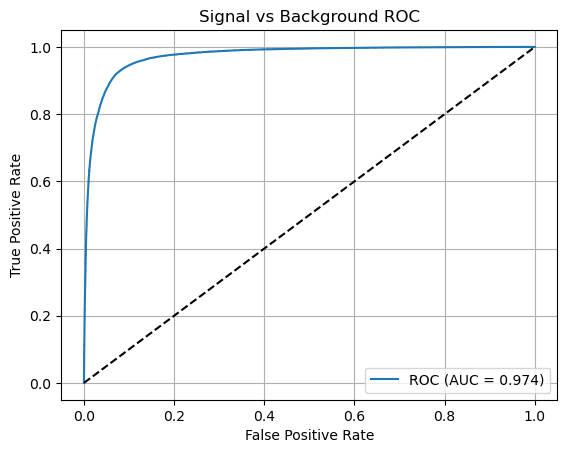

In [28]:
fpr, tpr, thresholds = roc_curve(y_val, scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Signal vs Background ROC')
plt.legend()
plt.grid(True)
plt.show()


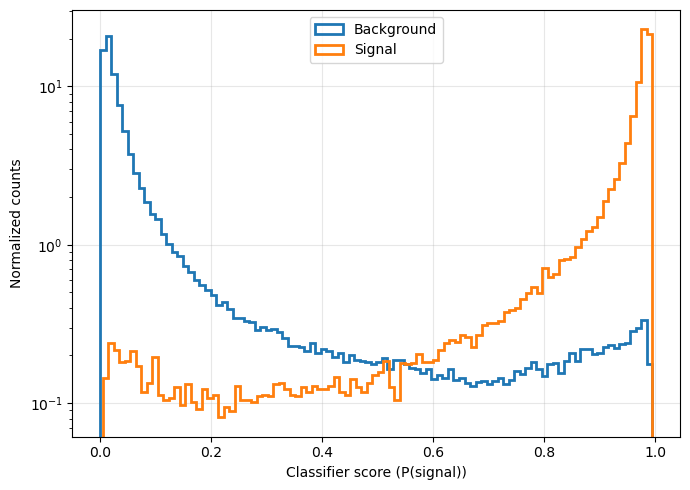

0.8944535455183712 0.9421950853310646


In [11]:
signal_scores     = scores[labels == 1]
background_scores = scores[labels == 0]

plt.figure(figsize=(7,5))

bins = 100

plt.hist(background_scores,bins=bins,density=True,histtype='step',linewidth=2,label='Background')
plt.hist(signal_scores,bins=bins,density=True,histtype='step',linewidth=2,label='Signal')

plt.xlabel("Classifier score (P(signal))")
plt.ylabel("Normalized counts")
plt.legend()
plt.grid(alpha=0.3)

plt.semilogy()
plt.tight_layout()
plt.show()

cut = 0.7
signal_eff = (signal_scores > cut).mean()
bkg_rej = 1 - (background_scores > cut).mean()
print(signal_eff, bkg_rej)

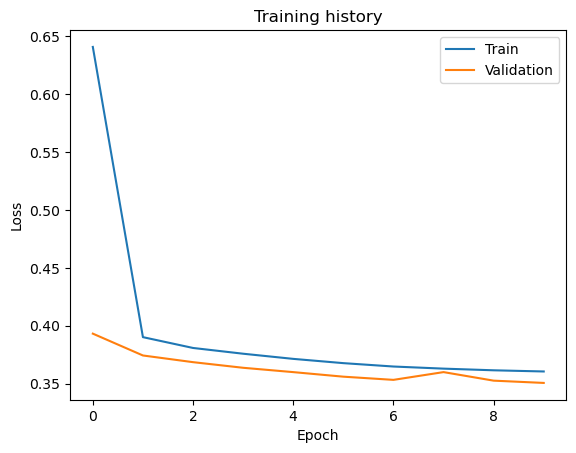

In [12]:


plt.figure()
plt.plot(train_loss_hist, label='Train')
plt.plot(val_loss_hist, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training history')
plt.show()



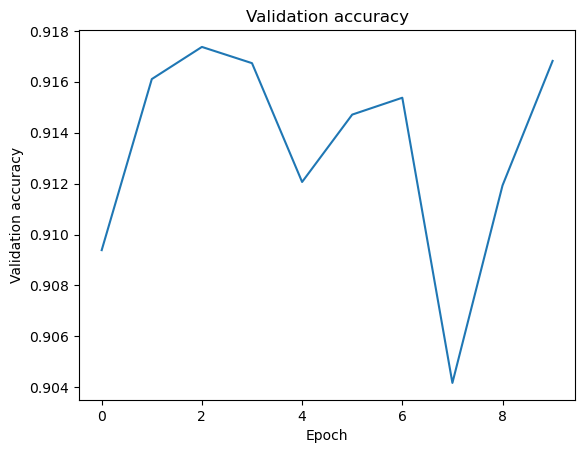

In [13]:
plt.figure()
plt.plot(val_acc_hist)
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy')
plt.show()

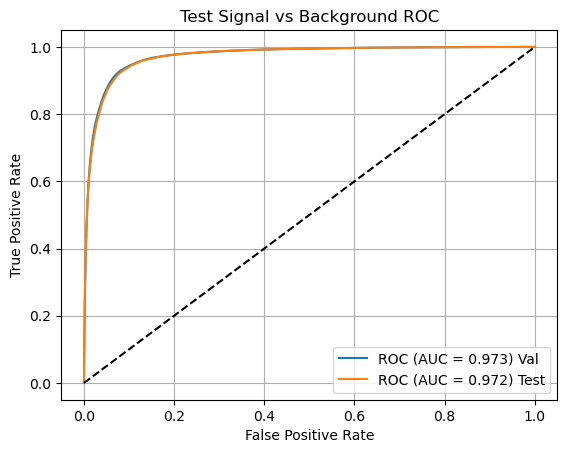

In [14]:
# Test metrics

model.eval()
with torch.no_grad():
    logits_test = model(X_test_tensor)
    scores_test = torch.sigmoid(logits_test).cpu().numpy().ravel() # converts logits back to probability
    labels_test = y_test_tensor.cpu().numpy().ravel()


fpr_test, tpr_test, thresholds_test = roc_curve(y_test, scores_test)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f}) Val')
plt.plot(fpr_test, tpr_test, label=f'ROC (AUC = {roc_auc_test:.3f}) Test')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Signal vs Background ROC')
plt.legend()
plt.grid(True)
plt.show()


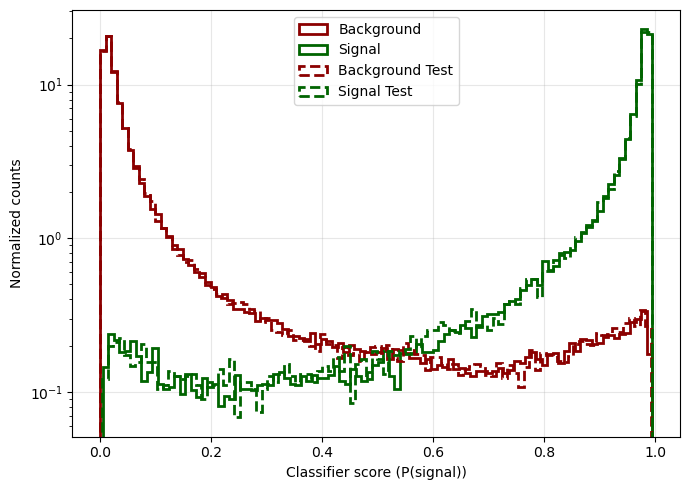

0.88579749336939 0.9422284503611764


In [15]:
signal_scores_test     = scores_test[labels_test == 1]
background_scores_test = scores_test[labels_test == 0]

plt.figure(figsize=(7,5))

bins = 100

plt.hist(background_scores,bins=bins,density=True,histtype='step',linewidth=2,label='Background', color = "darkred")
plt.hist(signal_scores,bins=bins,density=True,histtype='step',linewidth=2,label='Signal', color = "darkgreen")

plt.hist(background_scores_test,bins=bins,density=True,histtype='step',linewidth=2,label='Background Test', color = "darkred", linestyle = "--")
plt.hist(signal_scores_test,bins=bins,density=True,histtype='step',linewidth=2,label='Signal Test', color = "darkgreen", linestyle = "--")



plt.xlabel("Classifier score (P(signal))")
plt.ylabel("Normalized counts")
plt.legend()
plt.grid(alpha=0.3)

plt.semilogy()
plt.tight_layout()
plt.show()

signal_eff_test = (signal_scores_test > cut).mean()
bkg_rej_test = 1 - (background_scores_test > cut).mean()
print(signal_eff_test, bkg_rej_test)

In [16]:
# Plot some global information about the training across all events 

model.eval()

with torch.no_grad():
    X_tensor = torch.tensor(
        X.astype('float32').values,
        dtype=torch.float32
    )

    logits = model(X_tensor)
    p_signal = torch.sigmoid(logits).cpu().numpy().ravel()

df = df.copy()
df["p_signal"] = p_signal

display(df)

,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,...,blob2RTD,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label,contained,Type,subType,p_signal
0,122,0,1,0,100,0.750974,0.982111,0.196790,0.361191,0.504765,...,0.371672,2.045741,0.067698,2.065729,0.108244,Primary,True,0nubb,0nubb,0.933721
0,123,0,1,6,93,0.466155,0.906735,0.230215,0.384753,1.271497,...,0.527834,3.032524,0.150515,1.909019,0.150560,Primary,True,0nubb,0nubb,0.898601
0,124,0,1,18,69,0.493746,0.916694,0.274202,0.509693,1.047935,...,0.665134,2.249627,0.068509,1.386034,0.092338,Primary,True,0nubb,0nubb,0.949604
0,126,0,1,19,58,0.639797,0.977066,0.288765,0.456897,0.732130,...,0.674678,2.222126,0.086434,1.156343,0.099285,Primary,True,0nubb,0nubb,0.986775
0,127,0,1,17,74,0.478582,0.981282,0.351945,0.458388,0.912375,...,0.758123,2.391019,0.075850,1.326002,0.115086,Primary,True,0nubb,0nubb,0.981754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,70170,0,1,18,133,0.703980,0.988452,0.245332,0.294574,1.012560,...,0.190860,1.995170,0.002354,1.345982,0.018669,Primary,True,Bkg,single,0.128907
0,70171,0,1,4,80,0.725422,0.993637,0.238160,0.281076,0.682956,...,0.144321,2.472115,0.005970,2.136849,0.029046,Primary,True,Bkg,single,0.089598
0,70175,0,1,213,248,0.730802,0.987864,0.199231,0.180581,0.909667,...,0.108731,3.495141,0.008325,3.411146,0.027088,Primary,True,Bkg,single,0.017671
0,70176,0,1,62,116,0.492673,0.892517,0.272233,0.255566,1.244267,...,0.137920,1.896277,0.001702,0.976693,0.016458,Primary,True,Bkg,single,0.035136


Signal Eff: 0.9149500486252321
Tl ERej: 0.9329501032364499 14.46385755834575
Bi ERej: 0.9308621509879988 14.914266065561243
single ERej: 0.9183716252302255 12.250642044759692


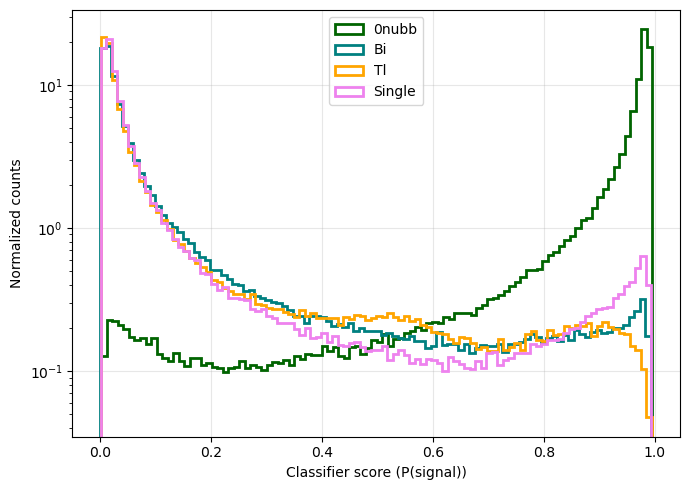

In [24]:
def CalcEfficiency(df, label, cut):
    num = len(df[ (df.subType == label) & (df.p_signal > cut)])
    den = len(df[ (df.subType == label)])
    return num/den

cut = 0.6

print("Signal Eff:",    CalcEfficiency(df, "0nubb",  cut))
print("Tl ERej:",     1-CalcEfficiency(df, "Tl", cut), 1/CalcEfficiency(df, "Bi",     cut))
print("Bi ERej:",     1-CalcEfficiency(df, "Bi", cut), 1/CalcEfficiency(df, "Tl",     cut))
print("single ERej:", 1-CalcEfficiency(df, "single", cut), 1/CalcEfficiency(df, "single", cut))

plt.figure(figsize=(7,5))

bins = 100

plt.hist(df[ (df.subType == "0nubb")].p_signal,bins=bins,density=True,histtype='step',linewidth=2,label='0nubb', color = "darkgreen");
plt.hist(df[ (df.subType == "Bi")].p_signal,bins=bins,density=True,histtype='step',linewidth=2,label='Bi', color = "Teal");
plt.hist(df[ (df.subType == "Tl")].p_signal,bins=bins,density=True,histtype='step',linewidth=2,label='Tl', color = "Orange");
plt.hist(df[ (df.subType == "single")].p_signal,bins=bins,density=True,histtype='step',linewidth=2,label='Single', color = "violet");


plt.xlabel("Classifier score (P(signal))")
plt.ylabel("Normalized counts")
plt.legend()
plt.grid(alpha=0.3)

plt.semilogy()
plt.tight_layout()
plt.show()



In [18]:
# # Write the event ids to a file
print(cut)
df_out = df.copy()
df_out['subType'] = df_out['subType'].replace({'0nubb': 'ATPC_0nubb', 'Bi': 'ATPC_Bi_ion', 'Tl': 'ATPC_Tl_ion', 'single': 'ATPC_single'})
df_out = df_out[["event_id", "subType", "p_signal"]]
df_out = df_out[df_out.p_signal > cut]
display(df_out)


df_out[["event_id", "subType"]].to_csv("../data/SelectedEvents/ATPC_1bar_5percent.csv", index=False)

print(len(df_out[df_out.subType == "ATPC_Bi_ion"]))

0.95


,event_id,subType,p_signal
0,126,ATPC_0nubb,0.986775
0,127,ATPC_0nubb,0.981754
0,128,ATPC_0nubb,0.988893
0,129,ATPC_0nubb,0.974151
0,132,ATPC_0nubb,0.987737
...,...,...,...
0,6974245,ATPC_single,0.967516
0,69853,ATPC_single,0.978503
0,70027,ATPC_single,0.971722
0,70046,ATPC_single,0.978724


2147
